In [1]:
import pyneb as pn
from pyneb.utils.physics import CST
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

2024-09-10 20:14:14.937562: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/christophemorisset/anaconda3/envs/ML/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
class test_Nc(object):

    def __init__(self, atom, ion, tem=1e4, i1=2, i2=3, j1=1, j2=1, n1_lit=None, n2_lit=None):

        self.ION = pn.Atom(atom, ion)
        self.tem = tem
        self.i1 = i1
        self.i2 = i2
        self.j1 = j1
        self.j2 = j2            
        self.n1_lit = n1_lit
        self.n2_lit = n2_lit

        self.Om_12 = self.ION.getOmega(self.tem, i1, j1)
        self.Om_13 = self.ION.getOmega(self.tem, i2, j2)
        self.A_21 = self.ION.getA(i1, j1)
        self.A_31 = self.ION.getA(i2, j2)
        self.E_21 = self.ION.getEnergy(i1) - self.ION.getEnergy(j1) # in Ang-1
        self.E_31 = self.ION.getEnergy(i2) - self.ION.getEnergy(j2)

        self.q_21 = CST.KCOLLRATE / self.tem**0.5 * self.Om_12 / self.ION.getStatWeight(i1) # desexcitation
        self.q_31 = CST.KCOLLRATE / self.tem**0.5 * self.Om_13 / self.ION.getStatWeight(i2)
        self.q_12 = self.q_21 * self.ION.getStatWeight(i1) / self.ION.getStatWeight(j1) * np.exp(-self.E_21/self.tem/CST.BOLTZMANN_ANGK) #excitation
        self.q_13 = self.q_31 * self.ION.getStatWeight(i2) / self.ION.getStatWeight(j2) * np.exp(-self.E_31/self.tem/CST.BOLTZMANN_ANGK)
        self.q_2 = self.ION.getCollRates(self.tem).sum(1)[i1-1]
        self.q_3 = self.ION.getCollRates(self.tem).sum(1)[i2-1]

        n1, n2 = self.ION.getDensityRange( lev_i1=i1,lev_i2=i2, lev_j1=j1,lev_j2=j2, tem=self.tem, tol=0.1)

        self.den = np.logspace(np.log10(n1)-1.5, np.log10(n2)+1.5,100)
        self.R_lines = self.ION.getEmissivity(self.tem, self.den, lev_i=i1, lev_j=j1) / self.ION.getEmissivity(self.tem, self.den, lev_i=i2, lev_j=j2)
        print(f"{self.ION.atom} Levels: {i1}-{j1} / {i2}-{j2}, Line ratio {self.ION.wave_Ang[i1-1,j1-1]:.0f} / {self.ION.wave_Ang[i2-1,j2-1]:.0f}")
    
    def print_ncrits(self):
        print(f'A_ij/q_ji: {self.A_21/self.q_12:.2e}, {self.A_31/self.q_13:.2e}, A_ij/q_ij: {self.A_21/self.q_21:.2e}, {self.A_31/self.q_31:.2e}, A_ij/q_i: {self.A_21/self.q_2:.2e}, {self.A_31/self.q_3:.2e} Lev nc: {self.ION.getCritDensity(self.tem, self.i1):.2e}  {self.ION.getCritDensity(self.tem, self.i2):.2e}')

    def plot_ratio(self, tol=0.1, ax=None):
    
        if ax is None:
            f, ax = plt.subplots(figsize=(7,5))
        else:
            f = plt.gcf()
        ax.plot(self.den, self.R_lines)

        ymin = np.min(self.R_lines)
        ymax = np.max(self.R_lines)
        delta_y = (ymax-ymin) / 7

        ax.set_title(self.ION.atom)

        n1, n2 = self.ION.getDensityRange( lev_i1=self.i1,lev_i2=self.i2, lev_j1=self.j1,lev_j2=self.j2, tem=self.tem, tol=tol)
        ax.vlines(n1, ymin, ymin+delta_y, color='r', lw=5,  label=f'Density range {tol:.2f}')
        ax.vlines(n2, ymin, ymin+delta_y, color='r', lw=5)

        ax.vlines(self.A_21/self.q_21, ymin+delta_y, ymin+2*delta_y, label='Aij/qij', lw=5)
        ax.vlines(self.A_31/self.q_31, ymin+delta_y, ymin+2*delta_y, lw=5)

        ax.vlines(self.A_21/self.q_2, ymin+2*delta_y, ymin+3*delta_y,color='g', lw=5, label='Aij/qi')
        ax.vlines(self.A_31/self.q_3, ymin+2*delta_y, ymin+3*delta_y,color='g', lw=5, )

        nc2 = self.ION.getCritDensity(self.tem, self.i1)
        nc3 = self.ION.getCritDensity(self.tem, self.i2)
        ax.vlines(nc2, ymin+3*delta_y, ymin+4*delta_y, color='m', lw=5, label='Crit Density i')
        ax.vlines(nc3, ymin+3*delta_y, ymin+4*delta_y, color='m', lw=5, )

        if self.n1_lit is not None:
            ax.vlines(self.n1_lit, ymin+4*delta_y, ymin+5*delta_y, color='y', lw=5, label='Litterature')
        if self.n2_lit is not None:
            ax.vlines(self.n2_lit, ymin+4*delta_y, ymin+5*delta_y, color='y', lw=5)

        ax.legend()

        ax.set_xscale('log')
        f.tight_layout()

    def plot_lines(self, tol=0.1, axes=None):

        if axes is None:
            f, (ax1,ax2) = plt.subplots(2,1,figsize=(5,9))
        else:
            ax1, ax2 = axes
            f = plt.gcf()

        e1 = self.ION.getEmissivity(self.tem, self.den, lev_i=self.i1, lev_j=self.j1)
        e2 = self.ION.getEmissivity(self.tem, self.den, lev_i=self.i2, lev_j=self.j2)

        ax1.plot(self.den, e1)
        ax2.plot(self.den, e2)
        ymin = np.min(e2)
        ymax = np.max(e2) * 3
        delta_y = (ymax/ymin)**(1/8)

        ax1.set_title(self.ION.atom)

        n2, n1 = self.ION.getDensityRange( lev_i1=self.i1,lev_i2=self.i2, lev_j1=self.j1,lev_j2=self.j2, tem=self.tem, tol=tol)
        ax1.vlines(n1, ymin, ymin*delta_y, color='r', lw=5, label=f'Density range {tol:.2f}')
        ax2.vlines(n2, ymin, ymin*delta_y, color='r', lw=5, label=f'Density range {tol:.2f}')

        ax1.vlines(self.A_21/self.q_21,  ymin*delta_y, ymin*delta_y**2, label='Aij/qij', lw=5)
        ax2.vlines(self.A_31/self.q_31,  ymin*delta_y, ymin*delta_y**2, label='Aij/qij', lw=5)

        ax1.vlines(self.A_21/self.q_2, ymin*delta_y**2, ymin*delta_y**3,color='g', lw=5, label='Aij/qi')
        ax2.vlines(self.A_31/self.q_3, ymin*delta_y**2, ymin*delta_y**3,color='g', lw=5, label='Aij/qi')

        nc2 = self.ION.getCritDensity(self.tem, self.i1)
        nc3 = self.ION.getCritDensity(self.tem, self.i2)
        ax1.vlines(nc2,ymin*delta_y**3, ymin*delta_y**4, color='m', lw=5, label='Crit Density i')
        ax2.vlines(nc3,ymin*delta_y**3, ymin*delta_y**4, color='m', lw=5, label='Crit Density i')

        if self.n1_lit is not None:
            ax1.vlines(self.n1_lit,ymin*delta_y**4, ymin*delta_y**5, color='y', lw=5, label='Litterature')
        if self.n2_lit is not None:
            ax2.vlines(self.n2_lit,ymin*delta_y**4, ymin*delta_y**5, color='y', lw=5)

        for ax in (ax1, ax2):
            ax.set_ylim(ymin, ymax)
            ax.legend(loc='upper right')
            ax.set_xscale('log')
            ax.set_yscale('log')
        f.tight_layout()

In [3]:
S2 = test_Nc('S', 2, n2_lit=1400, n1_lit=3600)
O2 = test_Nc('O', 2, i1=3, i2=2, n2_lit=1200, n1_lit=4300)
Cl3 = test_Nc('Cl',3)
Ar4 = test_Nc('Ar',4)
Ne5 = test_Nc('Ne',5, i1=3, i2=2, j1=2, j2=1, n2_lit=3e5)

S2 Levels: 2-1 / 3-1, Line ratio 6731 / 6716
O2 Levels: 3-1 / 2-1, Line ratio 3726 / 3729
Cl3 Levels: 2-1 / 3-1, Line ratio 5538 / 5518
Ar4 Levels: 2-1 / 3-1, Line ratio 4740 / 4711
Ne5 Levels: 3-2 / 2-1, Line ratio 143178 / 243108


In [4]:
S2.print_ncrits()
O2.print_ncrits()
Cl3.print_ncrits()
Ar4.print_ncrits()
Ne5.print_ncrits()

A_ij/q_ji: 1.45e+05, 2.92e+04, A_ij/q_ij: 1.71e+04, 5.15e+03, A_ij/q_i: 4.21e+03, 1.62e+03 Lev nc: 4.21e+03  1.62e+03
A_ij/q_ji: 6.56e+05, 1.01e+05, A_ij/q_ij: 1.38e+04, 3.18e+03, A_ij/q_i: 4.09e+03, 1.21e+03 Lev nc: 4.09e+03  1.21e+03
A_ij/q_ji: 2.51e+06, 2.40e+05, A_ij/q_ij: 1.87e+05, 2.66e+04, A_ij/q_i: 3.89e+04, 7.12e+03 Lev nc: 3.89e+04  7.12e+03
A_ij/q_ji: 2.96e+07, 1.66e+06, A_ij/q_ij: 1.42e+06, 1.18e+05, A_ij/q_i: 1.33e+05, 1.50e+04 Lev nc: 1.33e+05  1.50e+04
A_ij/q_ji: 2.82e+04, 9.17e+03, A_ij/q_ij: 4.24e+04, 2.59e+04, A_ij/q_i: 3.24e+04, 5.95e+03 Lev nc: 3.24e+04  5.95e+03


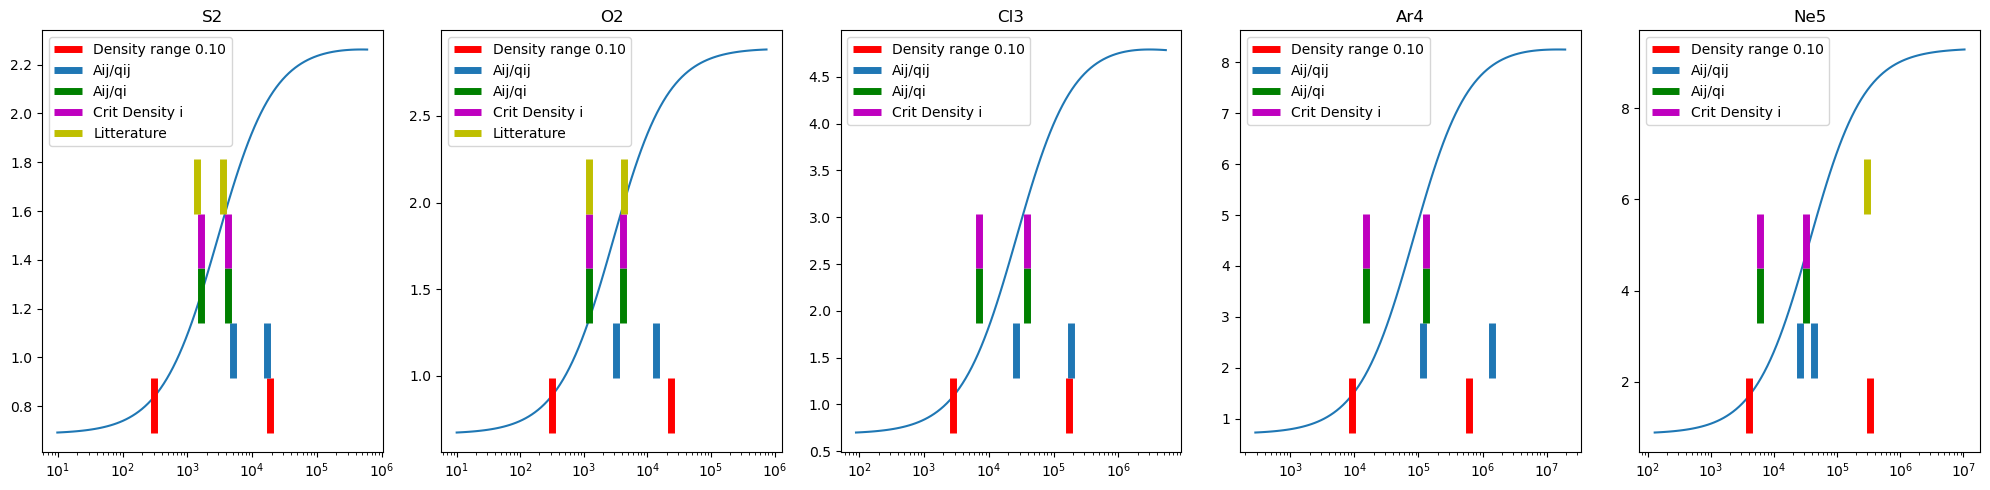

In [5]:
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5,figsize=(20,5))
tol = 0.1
S2.plot_ratio(tol=tol, ax=ax1)
O2.plot_ratio(tol=tol, ax=ax2)
Cl3.plot_ratio(tol=tol, ax=ax3)
Ar4.plot_ratio(tol=tol, ax=ax4)
Ne5.plot_ratio(tol=tol, ax=ax5)

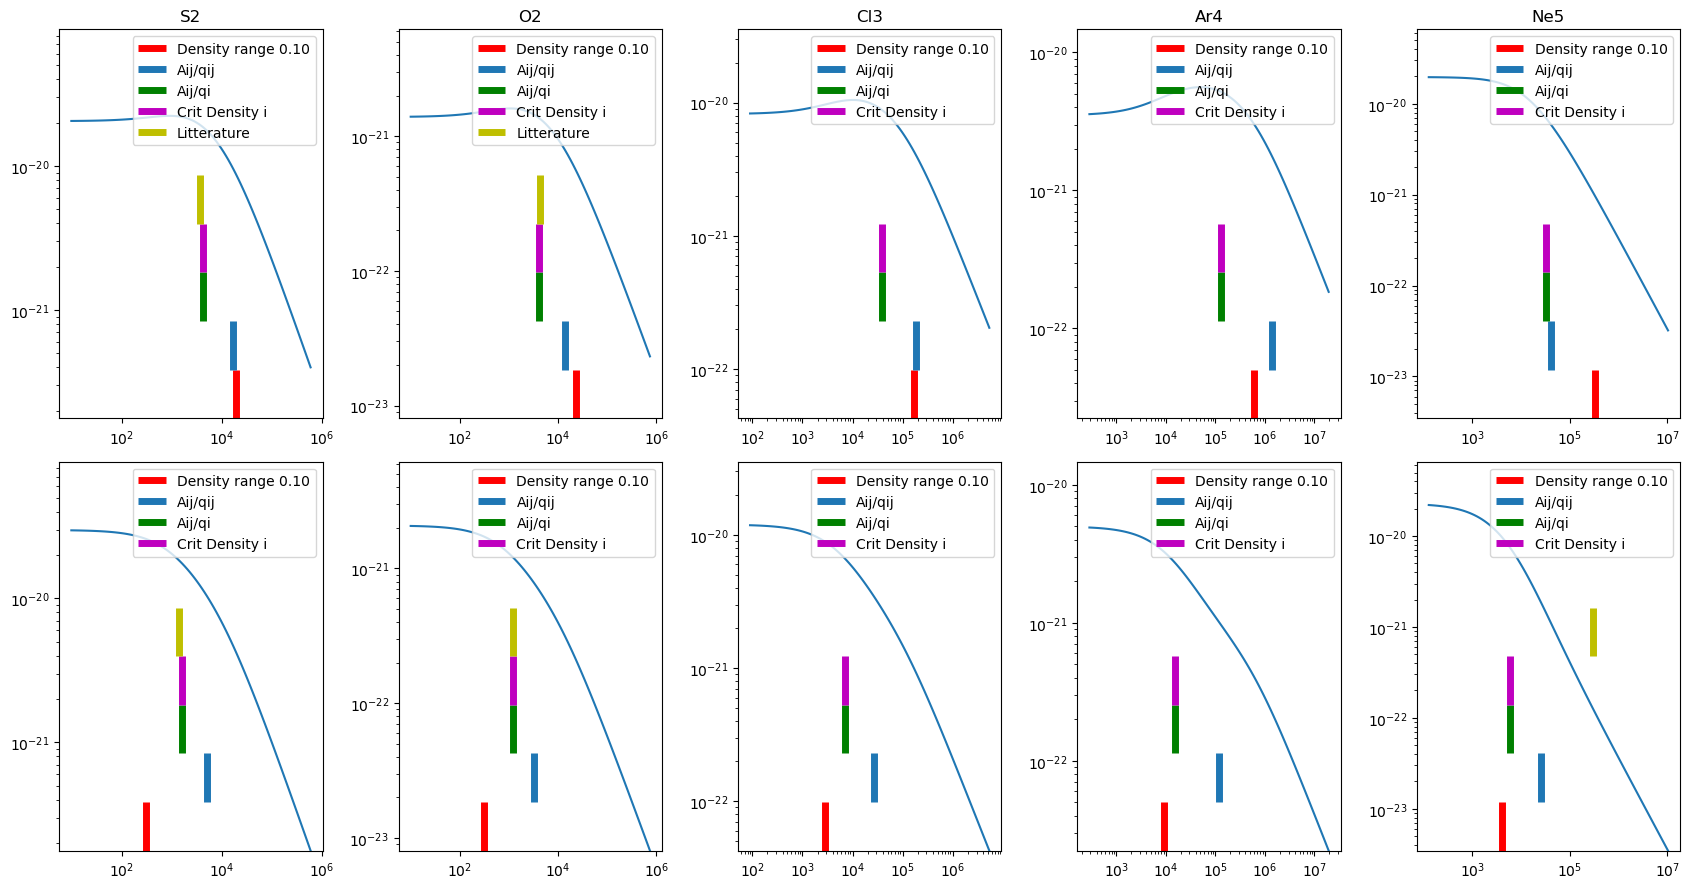

In [9]:
f, axes = plt.subplots(2,5,figsize=(17,9))
S2.plot_lines(tol=tol, axes=(axes[0,0], axes[1,0]))
O2.plot_lines(tol=tol, axes=(axes[0,1], axes[1,1]))
Cl3.plot_lines(tol=tol, axes=(axes[0,2], axes[1,2]))
Ar4.plot_lines(tol=tol, axes=(axes[0,3], axes[1,3]))
Ne5.plot_lines(tol=tol, axes=(axes[0,4], axes[1,4]))

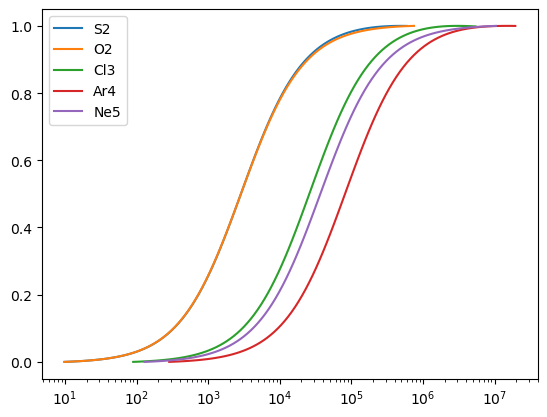

In [21]:
f, ax = plt.subplots()
for ion in (S2, O2, Cl3, Ar4, Ne5):
    ax.plot(ion.den, (ion.R_lines-np.min(ion.R_lines)) / (np.max(ion.R_lines)-np.min(ion.R_lines)), label=ion.ION.atom)

ax.set_xscale('log')
ax.legend();